<a href="https://colab.research.google.com/github/jjone36/Groot/blob/master/94_cnn_NeuralStyler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What if Van gogh had a visit to Seoul?  

I always love to visit art galleries and ~~

Neural style transfer is ~~

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [0]:
from skimage.transform import resize

import tensorflow as tf
from keras.applications.vgg16 import VGG16

## 1. Import data

In [3]:
# File upload
from google.colab import files
file = files.upload()

Saving gogh.jpg to gogh.jpg
Saving seoul.jpg to seoul.jpg


In [34]:
# Import the input image
input_img = plt.imread('/content/seoul.jpg')
input_img.shape

(540, 960, 3)

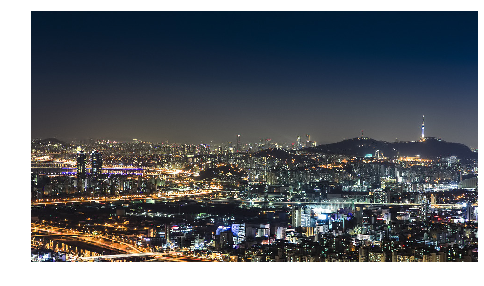

In [35]:
plt.imshow(input_img)
plt.axis('off')
plt.show()

In [36]:
# Setting
im_size = 512

input_img = resize(input_img, (im_size, im_size, 3))
input_img.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(500, 500, 3)

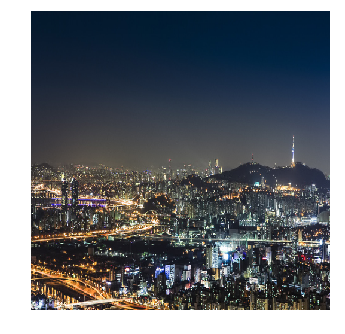

In [37]:
# Check
plt.imshow(input_img)
plt.axis('off')
plt.show()

(-0.5, 599.5, 414.5, -0.5)

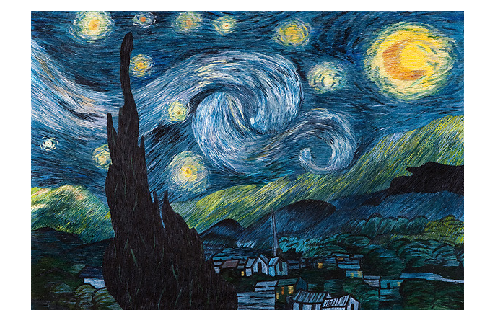

In [38]:
style_img = plt.imread('/content/gogh.jpg')

plt.imshow(style_img)
plt.axis('off')

In [39]:
style_img.shape

(415, 600, 3)

In [40]:
# Reshape the image
style_img = resize(style_img, (im_size, im_size, 3))
style_img.shape

/usr/local/lib/python3.6/dist-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


(500, 500, 3)

(-0.5, 499.5, 499.5, -0.5)

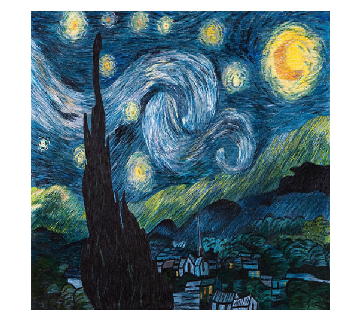

In [41]:
plt.imshow(style_img)
plt.axis('off')

In [0]:
# Transfer images to array
input_img_array = np.asarray(input_img, dtype = 'float32')
input_img_array = np.expand_dims(input_img_array, axis = 0)
input_img_array.shape

In [67]:
style_img_array = np.asarray(style_img, dtype = 'float32')
style_img_array = np.expand_dims(style_img_array, axis = 0)
style_img_array.shape

(1, 500, 500, 3)

In [0]:
# Normalization
content_array[:, :, :, 0] -= 103.939
content_array[:, :, :, 1] -= 116.779
content_array[:, :, :, 2] -= 123.68
content_array = content_array[:, :, :, ::-1]    # RGB -> BGR

style_array[:, :, :, 0] -= 103.939
style_array[:, :, :, 1] -= 116.779
style_array[:, :, :, 2] -= 123.68
style_array = style_array[:, :, :, ::-1]

# Loss function

In [0]:
# Content cost function
def content_cost(content, generated): 
  m, n_H, n_W, n_C = generated.get_shape().to_list()   # get the shape of image
  J_content = tf.sum(tf.square(content - generated)) / (4 * n_H * n_W * n_C)
  return J_content

Gram matrix is a matrix of dot products of vector V<sub>i</sub> and V<sub>j</sub> showing how similar the two vectors are. If they are highly similar, we would expect a large dot product and therefore high in G<sub>ij</sub>.


![alt text](https://github.com/jjone36/Coursera_deeplearning_ai/blob/master/course_4_Convolutional%20Neural%20Networks/images/gram.png)

In [0]:
# Gram matrix
def gram_matrix(A):
  return tf.matmul(A, tf.transpose(A))

In [0]:
# Style cost function for a layer
def layer_style_cost(style, generated):
  m, n_H, n_W, n_C = generated.get_shape().to_list()
  
  # getting the gram matrix
  style = tf.transpose(tf.reshape(style, [n_H * n_W, n_C]))
  style_gm = gram_matrix(style)
  
  generated = tf.transpose(tf.reshape(generated, [n_H * n_W, n_C]))
  generated_gm = gram_matrix(generated)
  
  # computing the cost 
  layer_J_style = tf.sum(tf.square(style_gm - generated_gm)) / (4 * n_C**2 * (n_H * n_W)**2)
  
  return layer_J_style

In [51]:
# VGG16 model application
model = VGG16(include_top = False, input_shape = (im_size, im_size, 3))

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]

In [0]:
def style_cost(layers):
  J_style = 0 
  
  for layer in style_layers:
    
    out = model[layer]
    
    style = sess.run(out)
    generated = out
    
    layer_J_style = layer_style_cost(style, generated)
    
    J_style += layer_J_style
    
    return J_style

In [0]:
def total_cost(J_content, J_style, a = 10, b = 40):
  J = a * J_content + b * J_style
    return J